
# Unsupervised learning

In this task, we will look at how data dimensionality reduction and clustering methods work. At the same time, we'll practice solving classification task again.

We will work with the [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. Download the data [here](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). The data comes from accelerometers and gyros of Samsung Galaxy S3 mobile phones ( you can find more info about the features using the link above), the type of activity of a person with a phone in his/her pocket is also known – whether he/she walked, stood, lay, sat or walked up or down the stairs.

First, we pretend that the type of activity is unknown to us, and we will try to cluster people purely on the basis of available features. Then we solve the problem of determining the type of physical activity as a classification problem.


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans

RANDOM_STATE = 17

In [ ]:
#import desde drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change this if necessary
PATH_TO_SAMSUNG_DATA = "/content/drive/My Drive/DataSets"

In [ ]:
X_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA,
                                  "samsung_train_labels.txt")).astype(int)

X_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA, "samsung_test.txt"))
y_test = np.loadtxt(os.path.join(PATH_TO_SAMSUNG_DATA,
                                  "samsung_test_labels.txt")).astype(int)

In [ ]:
# Checking dimensions
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

For clustering, we do not need a target vector, so we'll work with the combination of training and test samples. Merge `X_train` with `X_test`, and `y_train` with `y_test`.

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [ ]:
X.shape

(10299, 561)

Define the number of unique values of the labels of the target class.

In [ ]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [ ]:
n_classes = np.unique(y).size

[These labels correspond to:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 – walking
- 2 – walking upstairs
- 3 – walking downstairs
- 4 – sitting
- 5 – standing
- 6 – laying down

Scale the sample using `StandardScaler` with default parameters.

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X) 

Reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the original (scaled) data. Use the scaled dataset and fix `random_state` (RANDOM_STATE constant).

In [ ]:
pca = PCA(n_components=0.90, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X)

** Question 1: ** <br>
What is the minimum number of principal components required to cover the 90% of the variance of the original (scaled) data?

In [ ]:
X_pca.shape

(10299, 65)

**Answer options:**
- 56 
- 65
- 66
- 193

In [ ]:
round(float(pca.explained_variance_ratio_[0] * 100))

**Вопрос 2:**<br>
What percentage of the variance is covered by the first principal component? Round to the nearest percent.

**Answer options:**
- 45
- 51 
- 56
- 61

In [ ]:
pca.explained_variance_ratio_

array([0.50738221, 0.06239186, 0.02692564, 0.02452871, 0.01888936,
       0.01631395, 0.01414533, 0.01216211, 0.00985248, 0.00949228,
       0.00858304, 0.0080998 , 0.00765863, 0.00676668, 0.00630242,
       0.00615718, 0.00595335, 0.00577195, 0.00563431, 0.0054083 ,
       0.00518828, 0.00502742, 0.00473229, 0.00463818, 0.00446848,
       0.00439868, 0.00416863, 0.00400809, 0.00389072, 0.00381339,
       0.0036687 , 0.00364357, 0.00349225, 0.00346736, 0.00335539,
       0.00329411, 0.00323824, 0.00300508, 0.00294254, 0.00290452,
       0.00275765, 0.00269864, 0.00264196, 0.0025803 , 0.00255031,
       0.00247776, 0.00245537, 0.0023829 , 0.00235902, 0.00232044,
       0.0022836 , 0.00219182, 0.00212631, 0.00209145, 0.0020348 ,
       0.00201167, 0.00198111, 0.00194391, 0.00192509, 0.00189539,
       0.00186403, 0.00182923, 0.00180956, 0.00176364, 0.00174188])

Visualize data in projection on the first two principal components.

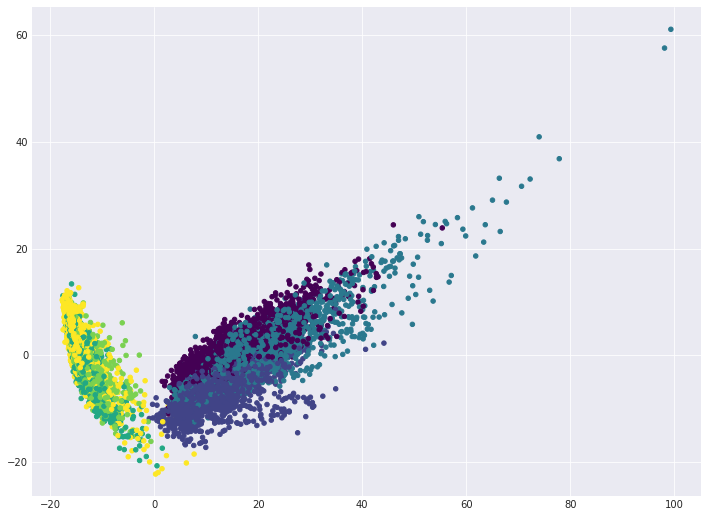

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:,1] , c=y, s=20, cmap='viridis');

**Question 3:**<br>
If everything worked out correctly, you will see a number of clusters, almost perfectly separated from each other. What types of activity are included in these clusters? <br>

**Answer options:**
- 1 cluster: all 6 activities
- 2 clusters: (walking, walking upstairs, walking downstairs ) and (sitting, standing, laying)
- 3 clusters: (walking), (walking upstairs, walking downstairs) and (sitting, standing, laying)
- 6 clusters

------------------------------

Perform clustering with the `KMeans` method, training the model on data with reduced dimensionality (by PCA). In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be looking for.

Options:

- ** n_clusters ** = n_classes (number of unique labels of the target class)
- ** n_init ** = 100
- ** random_state ** = RANDOM_STATE (for reproducibility of the result)

Other parameters should have default values.

In [ ]:
n_classes

6

In [ ]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_
cluster_labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

Visualize data in projection on the first two principal components. Color the dots according to the clusters obtained.

In [ ]:
np.unique(cluster_labels, return_counts=True)



(array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([2470, 2631, 1927, 1343,  279, 1649]))

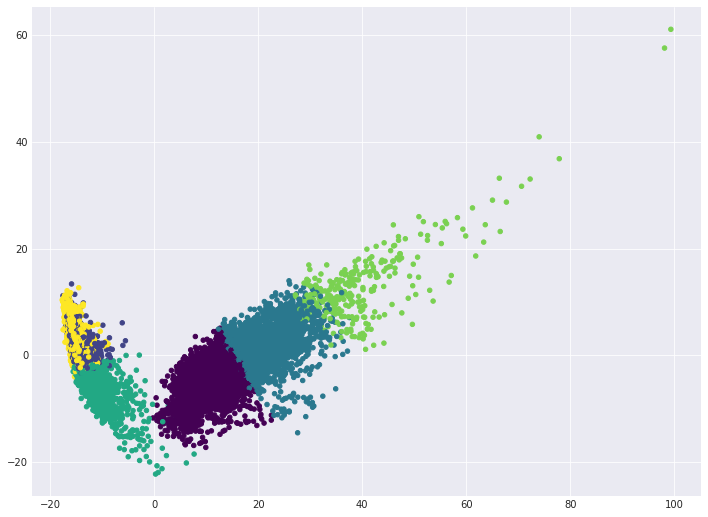

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap='viridis');

Look at the correspondence between the cluster marks and the original class labels and what kinds of activities the `KMeans` algorithm is confused at.

In [ ]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,903,0,741,0,78,0,1722
going up the stairs,1241,0,296,2,5,0,1544
going down the stairs,320,0,890,0,196,0,1406
sitting,1,1235,0,450,0,91,1777
standing,0,1344,0,562,0,0,1906
laying,5,52,0,329,0,1558,1944
all,2470,2631,1927,1343,279,1649,10299


We see that for each class (i.e., each activity) there are several clusters. Let's look at the maximum percentage of objects in a class that are assigned to a single cluster. This will be a simple metric that characterizes how easily the class is separated from others when clustering.


Example: if for class "walking downstairs" (with 1406 instances belonging to it), the distribution of clusters is:
 - cluster 1 - 900
 - cluster 3 - 500
 - cluster 6 - 6,
 
then such a share will be 900/1406 $ \approx $ 0.64.
 

** Question 4: ** <br>
Which activity is separated from the rest better than others based on the simple metric described above? <br>

**Answer:**
- walking
- standing
- walking downstairs
- all three options are incorrect

In [ ]:
type(tab)

pandas.core.frame.DataFrame

In [ ]:
tab2 = tab.iloc[:-1, :-1]
tab2

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
walking,903,0,741,0,78,0
going up the stairs,1241,0,296,2,5,0
going down the stairs,320,0,890,0,196,0
sitting,1,1235,0,450,0,91
standing,0,1344,0,562,0,0
laying,5,52,0,329,0,1558


In [ ]:
rows = tab2.max(axis=1)
rows/tab['all']

all                           NaN
going down the stairs    0.633001
going up the stairs      0.803756
laying                   0.801440
sitting                  0.694992
standing                 0.705142
walking                  0.524390
dtype: float64

It can be seen that kMeans does not distinguish activities very well. Use the elbow method to select the optimal number of clusters. Parameters of the algorithm and the data we use are the same as before, we change only `n_clusters`.

In [ ]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
  kmeans = KMeans(n_clusters=k, n_init=100, 
                    random_state=RANDOM_STATE, n_jobs=1).fit(X_pca)
  inertia.append(np.sqrt(kmeans.inertia_))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


** Question 5: ** <br>
How many clusters can we choose according to the elbow method? <br>

**Answer options:**
- 1
- 2
- 3
- 4

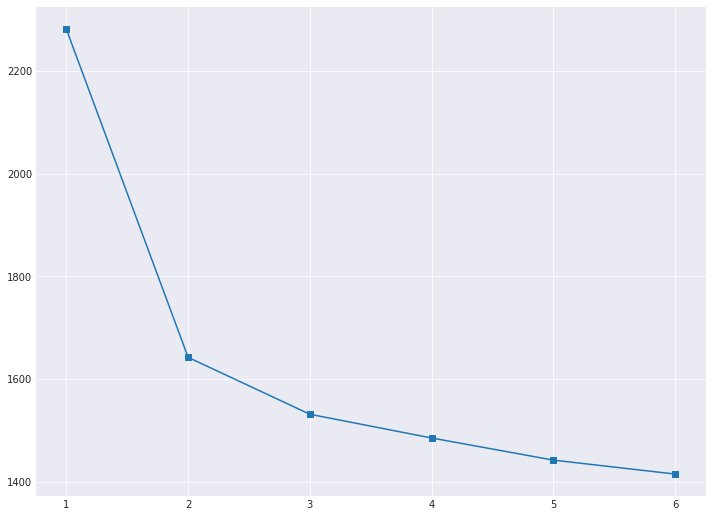

In [ ]:
plt.plot(range(1, 7), inertia, marker='s')